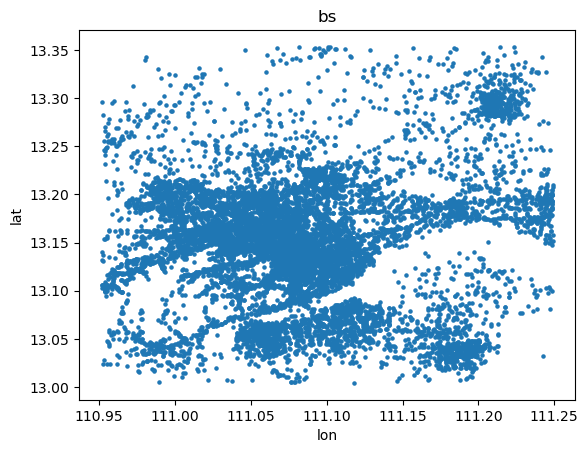

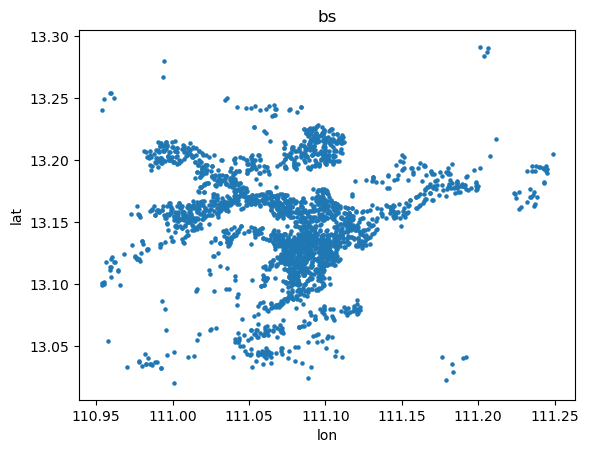

<Figure size 640x480 with 0 Axes>

In [39]:
# 展示拓扑图

import pandas as pd
import matplotlib.pyplot as plt
import os
current_directory = os.getcwd()

# 读取csv文件
df = pd.read_csv(current_directory + '/topology.csv')
# 绘制散点图
plt.scatter(df['lon'], df['lat'],s=5)
# 添加标题和坐标轴标签
plt.title('bs')
plt.xlabel('lon')
plt.ylabel('lat')
# 显示图形
plt.show()
plt.savefig(current_directory + '/origin.png')


df2 = pd.read_csv(current_directory + '/valid_topology.csv')
# 绘制散点图
plt.scatter(df2['lon'], df2['lat'],s=5)
# 添加标题和坐标轴标签
plt.title('bs')
plt.xlabel('lon')
plt.ylabel('lat')
# 显示图形
plt.show()
plt.savefig(current_directory + '/t.png')

In [4]:
# 将时间进行转换，并且只保留packets

import pandas as pd
from datetime import datetime, timedelta, timezone

# 定义北京时区
tz_beijing = timezone(timedelta(hours=8))

current_directory = os.getcwd()
# 读取csv文件
df = pd.read_csv( current_directory + '/cellular_traffic.csv')

# 定义一个函数，将UNIX纪元时间转换为常规日期和时间
def convert_time(time_hour):
    dt = datetime.fromtimestamp(time_hour, tz=tz_beijing)
    return dt.strftime('%Y-%m-%d %H:%M:%S')

# 应用函数，将time_hour列转换为常规日期和时间
df['time_hour'] = df['time_hour'].apply(convert_time)

df_pivot = df.pivot(index='time_hour', columns='bs', values='packets')

# 将结果保存到新的csv文件中
df_pivot.to_csv(current_directory + '/beijing_cellular_traffic.csv', index=True)

In [34]:
# 只保留拥有足够数据的bs


import pandas as pd
import os
current_directory = os.getcwd()
# 读取csv文件
df = pd.read_csv(current_directory + '/beijing_cellular_traffic.csv',index_col=0)

# 筛选出超过67个有效单元格的基站id
valid_bs = df.count(axis=0)
print(valid_bs,end='\n\n')
valid_bs_ids = valid_bs[valid_bs >= 190].index
print(valid_bs_ids,end='\n\n')

df_topology = pd.read_csv(current_directory + '/topology.csv')
# 将 'bs' 列转换为字符串类型
df_topology['bs'] = df_topology['bs'].astype(str)

valid_bs_info = df_topology[df_topology['bs'].isin(valid_bs_ids)]
print(valid_bs_info)
valid_bs_info.to_csv(current_directory + '/valid_topology.csv', index=False)

        
# 保留有效的基站id列
df_traffic_valid = df[valid_bs_ids]
# 输出到csv文件
df_traffic_valid.to_csv(current_directory + '/valid_bs.csv',index=True)

1        138
2        120
3        106
4        160
5         27
        ... 
13265      1
13266      1
13267      1
13268      1
13269      1
Length: 13269, dtype: int64

Index(['617', '626', '657', '787', '868', '901', '906', '1012', '1138', '1608',
       ...
       '7989', '7990', '7991', '7992', '7993', '7995', '7996', '7997', '7998',
       '7999'],
      dtype='object', length=2617)

        bs         lon        lat
616    617  111.075112  13.132426
625    626  111.049383  13.054832
656    657  111.041021  13.055985
786    787  111.089900  13.104513
867    868  111.038432  13.194015
...    ...         ...        ...
7994  7995  111.084888  13.110019
7995  7996  111.090853  13.115747
7996  7997  111.084914  13.112035
7997  7998  111.095695  13.195791
7998  7999  111.086408  13.111180

[2617 rows x 3 columns]


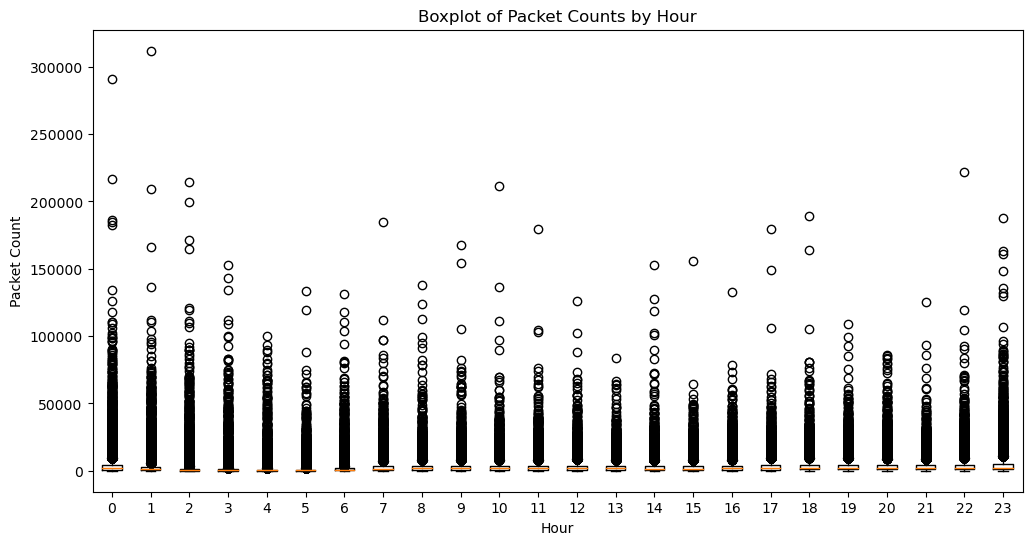

<Figure size 640x480 with 0 Axes>

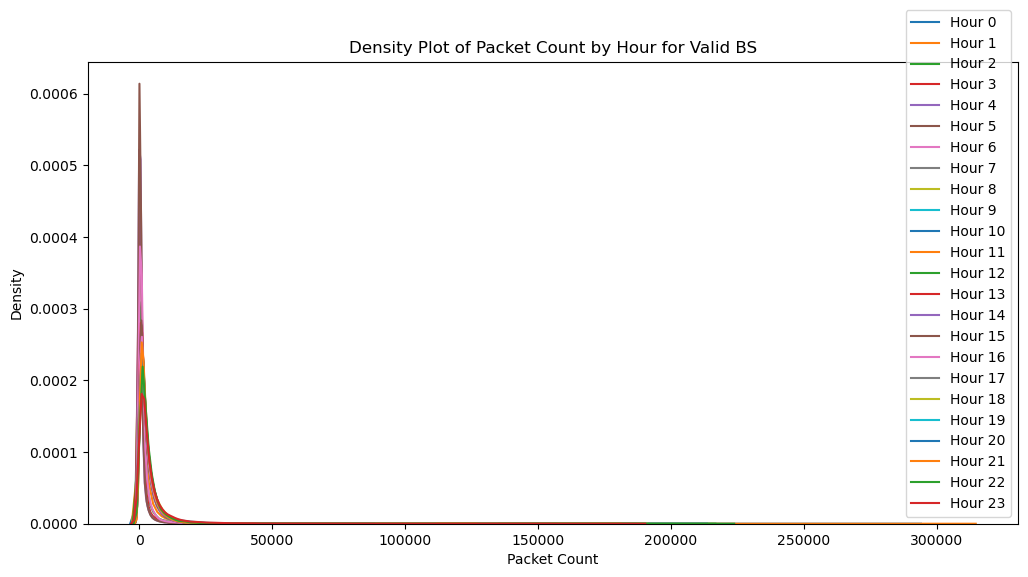

In [49]:
# 展示离群值，需要忽略掉nan，否则会影响箱线图

import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np

current_directory = os.getcwd()
# 读取csv文件
df = pd.read_csv(current_directory + '/valid_bs.csv',index_col=0)

# 将时间戳索引转换为datetime对象，并提取小时数
df.index = pd.to_datetime(df.index)
hours = df.index.hour

# 创建一个空的列表来保存按小时分组的数据
grouped = [df[hours == hour].values.flatten() for hour in range(24)]
grouped = [values[~np.isnan(values)] for values in grouped]

# print(grouped)
# 制作箱线图
plt.figure(figsize=(12, 6))
plt.boxplot(grouped, labels=range(24), positions=range(24))
plt.title('Boxplot of Packet Counts by Hour')
plt.xlabel('Hour')
plt.ylabel('Packet Count')
plt.xticks(range(24))  # 设置x轴的刻度位置和标签为0~23小时
plt.show()

plt.savefig( current_directory + '/outlier.png')


# 绘制每个小时的密度图
plt.figure(figsize=(12, 6))
for hour, values in enumerate(grouped):
    sns.kdeplot(values, label=f'Hour {hour}')
plt.xlabel('Packet Count')
plt.ylabel('Density')
plt.title('Density Plot of Packet Count by Hour for Valid BS')
plt.legend()
plt.show()

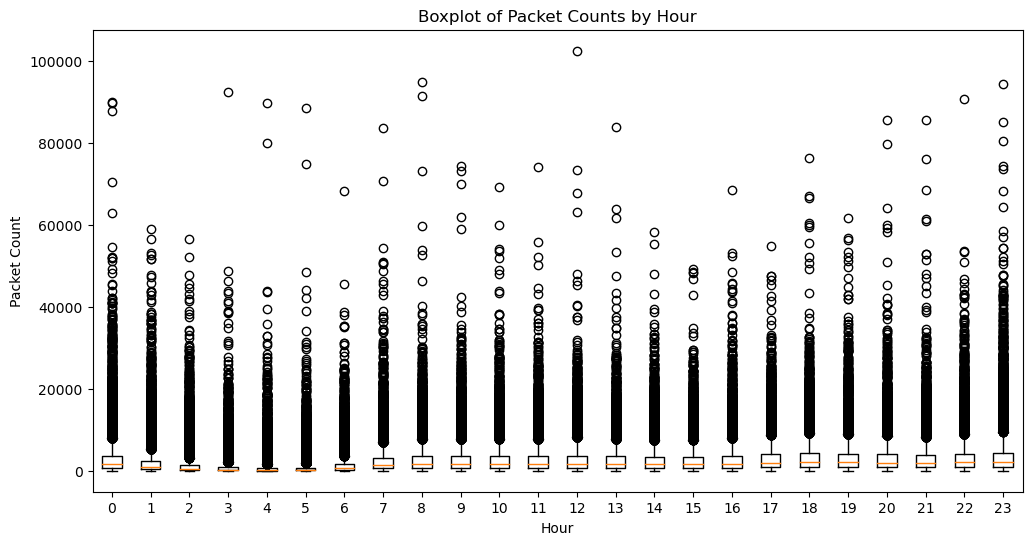

<Figure size 640x480 with 0 Axes>

In [50]:
# 去除离群值

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

import os
current_directory = os.getcwd()
# 读取csv文件
df = pd.read_csv(current_directory + '/valid_bs.csv',index_col=0)


# 计算Z-score
z_scores = stats.zscore(df,nan_policy='omit')
# print(z_scores)
# 设置阈值
threshold = 3

# 将Z-score大于阈值的值设置为NaN
df[(np.abs(z_scores) > threshold)] = np.nan
# 输出到csv文件
df.to_csv(current_directory + '/valid_removeoutlier_bs.csv')

# # 找到值超过800000的基站id和对应的时间戳
# result = df[df > 400000].stack().reset_index()
# # 输出结果
# print(result)

# 将时间戳索引转换为datetime对象，并提取小时数
df.index = pd.to_datetime(df.index)
hours = df.index.hour
# 创建一个空的列表来保存按小时分组的数据
grouped = [df[hours == hour].values.flatten() for hour in range(24)]
grouped = [values[~np.isnan(values)] for values in grouped]
# 制作箱线图
plt.figure(figsize=(12, 6))
plt.boxplot(grouped, labels=range(24), positions=range(24))
plt.title('Boxplot of Packet Counts by Hour')
plt.xlabel('Hour')
plt.ylabel('Packet Count')
plt.xticks(range(24))  # 设置x轴的刻度位置和标签为0~23小时
plt.show()

plt.savefig(current_directory + '/valid_removeoutlier_bs.png')

(192, 2617)
(192, 2617)


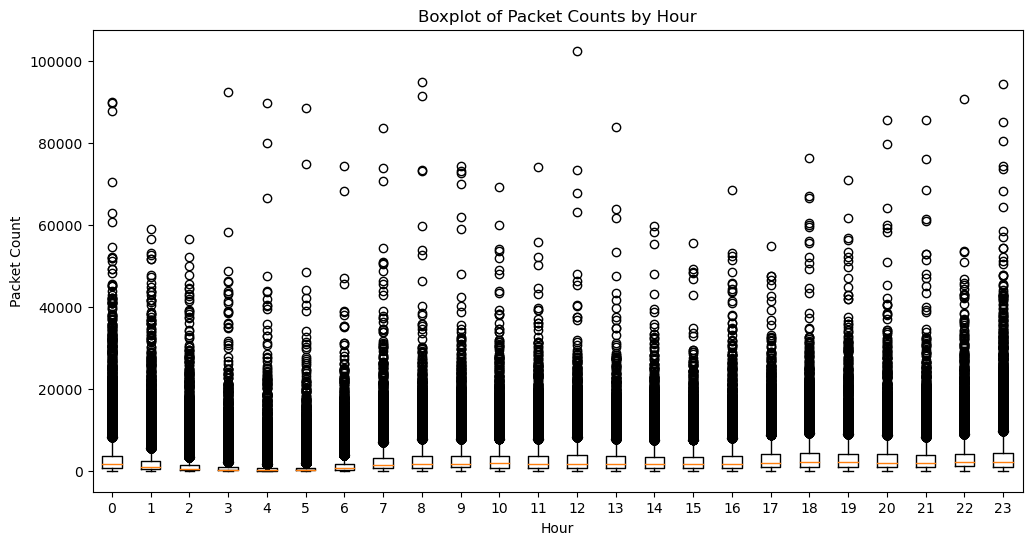

<Figure size 640x480 with 0 Axes>

In [19]:
# 填充NAN

import pandas as pd
import os
import matplotlib.pyplot as plt

current_directory = os.getcwd()
# 读取csv文件
df = pd.read_csv(current_directory + '/valid_removeoutlier_bs.csv', index_col=0)

# # 将NaN值替换为前一个小时的值
# df.fillna(method='ffill', inplace=True)

df = df.interpolate(method='linear')
print(df.shape)

df = df.fillna(method='ffill').fillna(method='bfill')

nan_locations = df.isna()

# 打印包含NaN值的行和列
for column in df.columns:
    if nan_locations[column].any():
        print(f"列 '{column}' 中的NaN值位于以下行：")
        print(nan_locations[nan_locations[column]].index.tolist())

# 删除包含NaN值的列
df = df.dropna(axis=1)
print(df.shape)
# # 找到值为NaN的行和列
# nan_rows = df[df.isnull().any(axis=1)]
# nan_cols = df.columns[df.isnull().any()].tolist()

# print('Rows with NaN values:')
# print(nan_rows)

# print('Columns with NaN values:')
# print(nan_cols)

# 将时间戳索引转换为datetime对象，并提取小时数
df.index = pd.to_datetime(df.index)
hours = df.index.hour
# 创建一个空的列表来保存按小时分组的数据
grouped = [df[hours == hour].values.flatten() for hour in range(24)]
grouped = [values[~np.isnan(values)] for values in grouped]

# 制作箱线图
plt.figure(figsize=(12, 6))
plt.boxplot(grouped, labels=range(24), positions=range(24))
plt.title('Boxplot of Packet Counts by Hour')
plt.xlabel('Hour')
plt.ylabel('Packet Count')
plt.xticks(range(24))  # 设置x轴的刻度位置和标签为0~23小时
plt.show()

plt.savefig(current_directory + '/fill_nan.png')

df.to_csv(current_directory + '/fill_nan.csv')

(192, 2617)


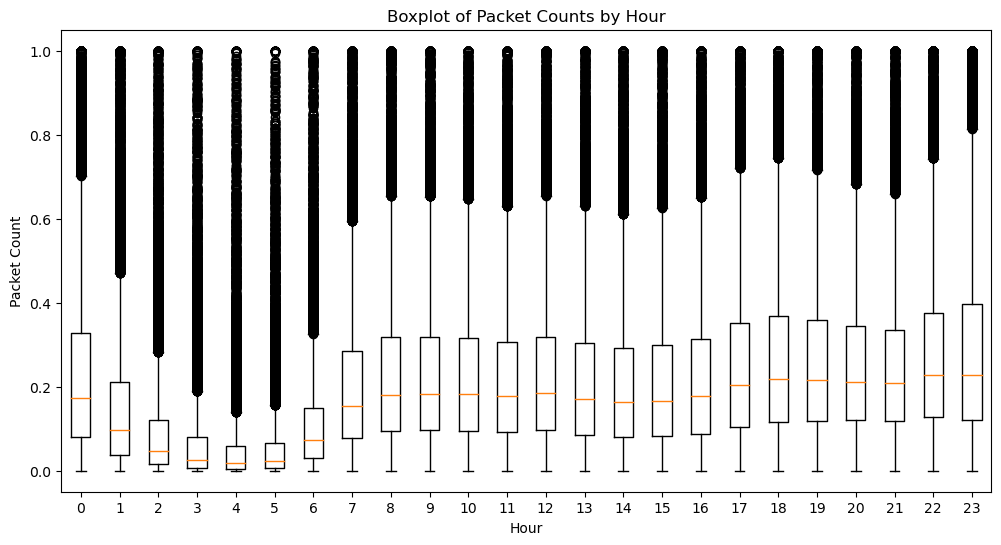

In [20]:
# normalization

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

current_directory = os.getcwd()
# 读取csv文件
df = pd.read_csv(current_directory + '/fill_nan.csv', index_col=0)
# 创建一个MinMaxScaler对象
scaler = MinMaxScaler()
# 对DataFrame的所有列进行归一化
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
print(df.shape)
df.index = pd.to_datetime(df.index)
hours = df.index.hour
# 创建一个空的列表来保存按小时分组的数据
grouped = [df[hours == hour].fillna(0).values.flatten() for hour in range(24)]
# 制作箱线图
plt.figure(figsize=(12, 6))
plt.boxplot(grouped, labels=range(24), positions=range(24))
plt.title('Boxplot of Packet Counts by Hour')
plt.xlabel('Hour')
plt.ylabel('Packet Count')
plt.xticks(range(24))  # 设置x轴的刻度位置和标签为0~23小时
plt.show()

# 保存新的CSV文件
df.to_csv(current_directory + '/normalized_file.csv')

In [10]:
import logging
import sys
import datetime

def init_logger(filename, logger_name):
    '''
    @brief:
        initialize logger that redirect info to a file just in case we lost connection to the notebook
    @params:
        filename: to which file should we log all the info
        logger_name: an alias to the logger
    '''
    # 创建一个logger
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.DEBUG)  # 设置日志级别
    logger.propagate = False  # 禁止日志传播
    # 创建一个handler，用于写入日志文件
    fh = logging.FileHandler(filename)
    fh.setLevel(logging.DEBUG)  # 设置handler的日志级别

    # 创建一个formatter，用于设置日志格式
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    # 将formatter添加到handler
    fh.setFormatter(formatter)

    # 将handler添加到logger
    logger.addHandler(fh)
    logger.info('### Init. Logger {} ###'.format(logger_name))
    return logger

# Initialize
czh_logger = init_logger("czh_notebook.log", "czh_logger")

In [ ]:
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from sklearn.metrics import silhouette_score
import os
current_directory = os.getcwd()

# 读取csv文件
df = pd.read_csv(current_directory + '/normalized_file.csv', index_col=0)
czh_logger.info(df.shape) # (192, 7521) ，论文示例显示是2,071个，说明我筛选力度不够大
# 将数据转换为适合tslearn处理的格式
formatted_data = df.T.values.reshape((df.shape[1], df.shape[0], 1))

clusters = 5
# 定义并训练模型
model = TimeSeriesKMeans(n_clusters=clusters, metric='dtw', verbose=False, max_iter=5, max_iter_barycenter=5, random_state=0)
labels = model.fit_predict(formatted_data)
# czh_logger.info(labels) arrary 输出不全，需要转换成label


# 将基站id和分类结果写入到文件中
with open(current_directory + '/cluster_label.txt', 'w') as f:
    for bs_id, label in zip(df.columns, labels):
        f.write(f'{bs_id}, {label}\n')
czh_logger.info(labels.shape)

# 计算Silhouette index，时间的大头花在这里
# silhouette_avg = silhouette_score(df.T, labels, metric=dtw) # (n_samples_a, n_features)
# czh_logger.info(f"Silhouette index: {silhouette_avg}")

In [3]:
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
import os
current_directory = os.getcwd()

X = random_walks(n_ts=1, sz=192, d=1)

model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5,
                          max_iter_barycenter=5,
                          random_state=0)
labels = model.fit_predict(X)


czh_logger.info(labels)


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import os
current_directory = os.getcwd()

# 读取csv文件
df = pd.read_csv(current_directory + '/valid_topology.csv')
sensor_ids = df['bs'].unique().tolist()
# 创建bs id到0,1,2...的映射
sensor_id_to_ind  = {bs_id: i for i, bs_id in enumerate(df['bs'].unique())}
df['bs'] = df['bs'].map(sensor_id_to_ind )
# 将经纬度转换为弧度
df[['lon', 'lat']] = np.radians(df[['lon', 'lat']])
# 计算haversine距离
distances = haversine_distances(df[['lat', 'lon']], df[['lat', 'lon']]) * 6371000
# 创建邻接矩阵
distances_matrix = pd.DataFrame(distances, index=df['bs'], columns=df['bs'])
distances_matrix_np = distances_matrix.values
# 邻接矩阵单位是米
# print(distances_matrix_np,end='\n\n')

normalized_k = 0.1
distances = distances_matrix_np[~np.isinf(distances_matrix_np)].flatten()
std = distances.std()
adj_mx = np.exp(-np.square(distances_matrix / std))
# Make the adjacent matrix symmetric by taking the max.
# adj_mx = np.maximum.reduce([adj_mx, adj_mx.T])
# Sets entries that lower than a threshold, i.e., k, to zero for sparsity.
# 这行代码将邻接矩阵中所有小于阈值normalized_k的元素设置为零。这样可以增加邻接矩阵的稀疏性，也就是说，只有那些距离较大（即原始距离矩阵中的值较大）的基站之间才会有连接。
adj_mx[adj_mx < normalized_k] = 0

print(f"sensor_ids: {sensor_ids}")
print(f"sensor_id_to_ind: {sensor_id_to_ind}")
print(f"adj_mx: {adj_mx}")
print(f"{type(adj_mx)}")
adj_mx = adj_mx.values
print(f"{type(adj_mx)}")

father_directory = os.path.abspath(os.path.dirname(os.getcwd()))

import pickle
with open(father_directory + "/data/traffic/data/sensor_graph/adj_mx.pkl", 'wb') as f:
    pickle.dump([sensor_ids, sensor_id_to_ind, adj_mx], f, protocol=2)

sensor_ids: [617, 626, 657, 787, 868, 901, 906, 1012, 1138, 1608, 1675, 1679, 1733, 1787, 1899, 1908, 1929, 1945, 1948, 2033, 2061, 2152, 2157, 2165, 2209, 2262, 2290, 2294, 2320, 2351, 2354, 2355, 2371, 2392, 2448, 2477, 2493, 2540, 2575, 2613, 2618, 2630, 2631, 2641, 2663, 2713, 2780, 2844, 2845, 2847, 2850, 2851, 2852, 2857, 2861, 2892, 2893, 2894, 2899, 2922, 2939, 2962, 2975, 2995, 3031, 3037, 3038, 3039, 3040, 3053, 3061, 3139, 3149, 3150, 3161, 3168, 3205, 3211, 3231, 3238, 3253, 3256, 3258, 3281, 3282, 3286, 3317, 3361, 3362, 3364, 3367, 3396, 3416, 3424, 3444, 3447, 3448, 3450, 3451, 3458, 3461, 3480, 3484, 3493, 3500, 3522, 3530, 3549, 3555, 3556, 3560, 3562, 3581, 3592, 3597, 3609, 3618, 3621, 3635, 3644, 3645, 3648, 3653, 3657, 3666, 3667, 3683, 3687, 3690, 3702, 3707, 3713, 3714, 3717, 3718, 3724, 3742, 3744, 3749, 3753, 3754, 3775, 3788, 3789, 3790, 3792, 3807, 3808, 3809, 3817, 3823, 3827, 3828, 3835, 3836, 3839, 3840, 3884, 3889, 3890, 3891, 3894, 3902, 3908, 3915, 3926

In [25]:
import pandas as pd
import os

current_directory = os.getcwd()

# 读取csv文件
df = pd.read_csv(current_directory + '/normalized_file.csv', index_col=0)

# 将DataFrame保存为HDF5文件
print(type(df.index))
df.index = pd.to_datetime(df.index) # str -> datetime ，是必要的
print(type(df.index))
df.to_hdf('normalized_file.h5', key='df', mode='w')

<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [23]:
import pandas as pd

# 假设dates是一个包含你的日期时间字符串的列表
dates = ['2012-08-19 00:00:00', '2012-08-19 01:00:00', '2012-08-19 02:00:00']

# 将字符串转换为日期时间类型
datetime_dates = pd.to_datetime(dates)
print(datetime_dates)

DatetimeIndex(['2012-08-19 00:00:00', '2012-08-19 01:00:00',
               '2012-08-19 02:00:00'],
              dtype='datetime64[ns]', freq=None)
